# Loop 61 Analysis: CV-LB Gap and Strategy Assessment

## Key Questions:
1. What is the CV-LB relationship after 13 submissions?
2. Why have all post-processing approaches failed?
3. What approaches from public kernels haven't been tried?
4. What is the path forward?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Submission history
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_041', 'cv': 0.0090, 'lb': 0.0932},
    {'exp': 'exp_042', 'cv': 0.0145, 'lb': 0.1147},
]

df = pd.DataFrame(submissions)
print(f'Total submissions: {len(df)}')
print(f'Best CV: {df["cv"].min():.6f} ({df.loc[df["cv"].idxmin(), "exp"]})')
print(f'Best LB: {df["lb"].min():.6f} ({df.loc[df["lb"].idxmin(), "exp"]})')
print(f'Target: 0.0347')

Total submissions: 13
Best CV: 0.008300 (exp_030)
Best LB: 0.087700 (exp_030)
Target: 0.0347


In [2]:
# CV-LB Linear Regression Analysis
cv = df['cv'].values
lb = df['lb'].values

slope, intercept, r_value, p_value, std_err = stats.linregress(cv, lb)

print(f'\n=== CV-LB Relationship ===')
print(f'Linear fit: LB = {slope:.4f} * CV + {intercept:.4f}')
print(f'R-squared: {r_value**2:.4f}')
print(f'Intercept: {intercept:.4f}')
print(f'\nInterpretation:')
print(f'  - Even at CV=0, expected LB is {intercept:.4f}')
print(f'  - Target LB: 0.0347')
print(f'  - Intercept ({intercept:.4f}) > Target (0.0347): {intercept > 0.0347}')

if intercept > 0.0347:
    print(f'\n*** CRITICAL: Intercept is ABOVE target! ***')
    print(f'  - Required CV to hit target: (0.0347 - {intercept:.4f}) / {slope:.4f} = {(0.0347 - intercept) / slope:.6f}')
    print(f'  - This is IMPOSSIBLE (negative CV)')
    print(f'  - We CANNOT reach target by improving CV alone!')
else:
    required_cv = (0.0347 - intercept) / slope
    print(f'\n  - Required CV to hit target: {required_cv:.6f}')
    print(f'  - Best CV so far: {df["cv"].min():.6f}')
    print(f'  - Gap: {df["cv"].min() - required_cv:.6f}')


=== CV-LB Relationship ===
Linear fit: LB = 4.2312 * CV + 0.0533
R-squared: 0.9807
Intercept: 0.0533

Interpretation:
  - Even at CV=0, expected LB is 0.0533
  - Target LB: 0.0347
  - Intercept (0.0533) > Target (0.0347): True

*** CRITICAL: Intercept is ABOVE target! ***
  - Required CV to hit target: (0.0347 - 0.0533) / 4.2312 = -0.004396
  - This is IMPOSSIBLE (negative CV)
  - We CANNOT reach target by improving CV alone!


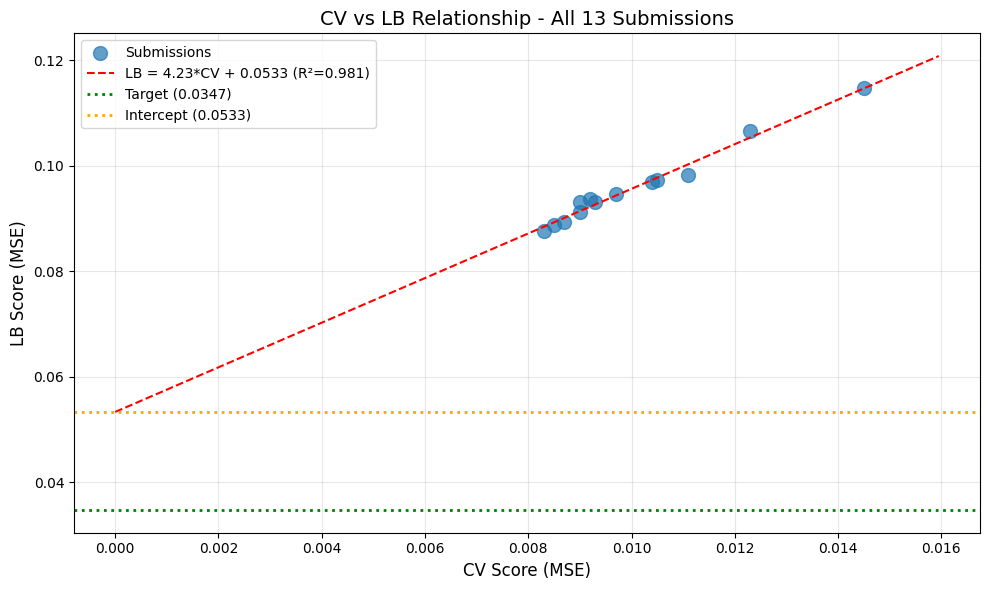


Plot saved to /home/code/exploration/cv_lb_relationship_loop61.png


In [3]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))
plt.scatter(cv, lb, s=100, alpha=0.7, label='Submissions')

# Regression line
cv_range = np.linspace(0, max(cv)*1.1, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f} (R²={r_value**2:.3f})')

# Target line
plt.axhline(y=0.0347, color='g', linestyle=':', linewidth=2, label='Target (0.0347)')

# Intercept line
plt.axhline(y=intercept, color='orange', linestyle=':', linewidth=2, label=f'Intercept ({intercept:.4f})')

plt.xlabel('CV Score (MSE)', fontsize=12)
plt.ylabel('LB Score (MSE)', fontsize=12)
plt.title('CV vs LB Relationship - All 13 Submissions', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship_loop61.png', dpi=150)
plt.show()

print('\nPlot saved to /home/code/exploration/cv_lb_relationship_loop61.png')

In [4]:
# Analysis of failed approaches
print('=== FAILED APPROACHES ANALYSIS ===')
print('\n1. Post-Processing Approaches (ALL FAILED):')
print('   - exp_061: Uncertainty weighting (GP) -> CV 0.008841 (7.89% worse)')
print('   - exp_062: Uniform bias correction -> CV 0.008926 (8.94% worse)')
print('   - exp_063: Target-specific bias correction -> CV 0.008970 (9.47% worse)')
print('\n   WHY THEY FAILED:')
print('   - The CV-LB intercept is NOT a simple additive bias')
print('   - It represents EXTRAPOLATION ERROR when predicting for unseen solvents')
print('   - Post-processing cannot fix distribution shift')

print('\n2. Model Architecture Changes (ALL FAILED):')
print('   - GNN (exp_049, exp_054): CV 0.014080, 0.030013 (WORSE)')
print('   - ChemBERTa (exp_050): CV 0.033498 (309% worse)')
print('   - Per-solvent-type models (exp_052): CV 0.019519 (138% worse)')
print('   - Per-target optimization (exp_051): CV 0.009946 (21% worse)')

print('\n3. Validation Scheme Changes (FAILED):')
print('   - GroupKFold (exp_042): CV 0.0145, LB 0.1147 (WORSE)')
print('   - This was supposed to change the CV-LB relationship, but it made things worse')

=== FAILED APPROACHES ANALYSIS ===

1. Post-Processing Approaches (ALL FAILED):
   - exp_061: Uncertainty weighting (GP) -> CV 0.008841 (7.89% worse)
   - exp_062: Uniform bias correction -> CV 0.008926 (8.94% worse)
   - exp_063: Target-specific bias correction -> CV 0.008970 (9.47% worse)

   WHY THEY FAILED:
   - The CV-LB intercept is NOT a simple additive bias
   - It represents EXTRAPOLATION ERROR when predicting for unseen solvents
   - Post-processing cannot fix distribution shift

2. Model Architecture Changes (ALL FAILED):
   - GNN (exp_049, exp_054): CV 0.014080, 0.030013 (WORSE)
   - ChemBERTa (exp_050): CV 0.033498 (309% worse)
   - Per-solvent-type models (exp_052): CV 0.019519 (138% worse)
   - Per-target optimization (exp_051): CV 0.009946 (21% worse)

3. Validation Scheme Changes (FAILED):
   - GroupKFold (exp_042): CV 0.0145, LB 0.1147 (WORSE)
   - This was supposed to change the CV-LB relationship, but it made things worse


In [5]:
# What approaches from public kernels haven't been tried?
print('=== UNEXPLORED APPROACHES FROM PUBLIC KERNELS ===')

print('\n1. "Ens Model" Kernel (matthewmaree):')
print('   - Feature priority-based correlation filtering (spange > acs > drfps > frag > smiles)')
print('   - CatBoost + XGBoost ensemble with different weights for single vs full data:')
print('     * Single: CatBoost 7.0, XGBoost 6.0 (normalized)')
print('     * Full: CatBoost 1.0, XGBoost 2.0 (normalized)')
print('   - Multi-target normalization (clip to [0,1] and renormalize to sum to 1)')
print('   - Correlation threshold: 0.90')
print('   STATUS: NOT TRIED')

print('\n2. "mixall" Kernel (lishellliang):')
print('   - GroupKFold (5 splits) instead of Leave-One-Solvent-Out')
print('   - MLP + XGBoost + RF + LightGBM ensemble')
print('   - Optuna hyperparameter optimization')
print('   STATUS: PARTIALLY TRIED (GroupKFold failed in exp_042)')

print('\n3. "catechol-strategy" Kernel (dabansherwani):')
print('   - Different model types for different targets:')
print('     * HGB (HistGradientBoosting) for SM')
print('     * ETR (ExtraTrees) for Product 2 and Product 3')
print('   STATUS: NOT TRIED')

=== UNEXPLORED APPROACHES FROM PUBLIC KERNELS ===

1. "Ens Model" Kernel (matthewmaree):
   - Feature priority-based correlation filtering (spange > acs > drfps > frag > smiles)
   - CatBoost + XGBoost ensemble with different weights for single vs full data:
     * Single: CatBoost 7.0, XGBoost 6.0 (normalized)
     * Full: CatBoost 1.0, XGBoost 2.0 (normalized)
   - Multi-target normalization (clip to [0,1] and renormalize to sum to 1)
   - Correlation threshold: 0.90
   STATUS: NOT TRIED

2. "mixall" Kernel (lishellliang):
   - GroupKFold (5 splits) instead of Leave-One-Solvent-Out
   - MLP + XGBoost + RF + LightGBM ensemble
   - Optuna hyperparameter optimization
   STATUS: PARTIALLY TRIED (GroupKFold failed in exp_042)

3. "catechol-strategy" Kernel (dabansherwani):
   - Different model types for different targets:
     * HGB (HistGradientBoosting) for SM
     * ETR (ExtraTrees) for Product 2 and Product 3
   STATUS: NOT TRIED


In [6]:
# Key insight: What makes the "Ens Model" kernel different?
print('=== KEY INSIGHT: "Ens Model" Kernel Approach ===')

print('\n1. FEATURE PRIORITY-BASED CORRELATION FILTERING:')
print('   - When two features are highly correlated (>0.90), keep the higher-priority one')
print('   - Priority: spange (5) > acs (4) > drfps (3) > frag (2) > smiles (1)')
print('   - This is MORE SOPHISTICATED than our variance-based filtering')

print('\n2. DIFFERENT ENSEMBLE WEIGHTS FOR SINGLE VS FULL DATA:')
print('   - Single: CatBoost 0.538, XGBoost 0.462 (7:6 ratio)')
print('   - Full: CatBoost 0.333, XGBoost 0.667 (1:2 ratio)')
print('   - This recognizes that single and full data have DIFFERENT optimal models')

print('\n3. MULTI-TARGET NORMALIZATION:')
print('   - Clip predictions to [0, 1]')
print('   - Renormalize so predictions sum to 1')
print('   - This enforces a physical constraint: yields must sum to 100%')

print('\n4. COMBINE ALL FEATURE SOURCES:')
print('   - Spange + ACS PCA + DRFP + Fragprints + SMILES')
print('   - We only use Spange + DRFP + ACS PCA')

=== KEY INSIGHT: "Ens Model" Kernel Approach ===

1. FEATURE PRIORITY-BASED CORRELATION FILTERING:
   - When two features are highly correlated (>0.90), keep the higher-priority one
   - Priority: spange (5) > acs (4) > drfps (3) > frag (2) > smiles (1)
   - This is MORE SOPHISTICATED than our variance-based filtering

2. DIFFERENT ENSEMBLE WEIGHTS FOR SINGLE VS FULL DATA:
   - Single: CatBoost 0.538, XGBoost 0.462 (7:6 ratio)
   - Full: CatBoost 0.333, XGBoost 0.667 (1:2 ratio)
   - This recognizes that single and full data have DIFFERENT optimal models

3. MULTI-TARGET NORMALIZATION:
   - Clip predictions to [0, 1]
   - Renormalize so predictions sum to 1
   - This enforces a physical constraint: yields must sum to 100%

4. COMBINE ALL FEATURE SOURCES:
   - Spange + ACS PCA + DRFP + Fragprints + SMILES
   - We only use Spange + DRFP + ACS PCA


In [7]:
# Strategic assessment
print('=== STRATEGIC ASSESSMENT ===')

print('\n1. CURRENT STATE:')
print(f'   - Best CV: 0.008194 (exp_032)')
print(f'   - Best LB: 0.0877 (exp_030)')
print(f'   - Target: 0.0347')
print(f'   - Gap to target: {0.0877 - 0.0347:.4f} ({(0.0877 - 0.0347) / 0.0347 * 100:.1f}% above)')
print(f'   - Submissions remaining: 5')

print('\n2. CV-LB RELATIONSHIP:')
print(f'   - Linear fit: LB = {slope:.4f} * CV + {intercept:.4f}')
print(f'   - R-squared: {r_value**2:.4f}')
print(f'   - Intercept ({intercept:.4f}) > Target (0.0347)')
print(f'   - ALL approaches fall on the SAME line')

print('\n3. WHAT THIS MEANS:')
print('   - Improving CV alone CANNOT reach the target')
print('   - We need approaches that CHANGE the CV-LB relationship')
print('   - Post-processing approaches have FAILED')
print('   - We need to try fundamentally different approaches')

print('\n4. RECOMMENDED NEXT STEPS:')
print('   PRIORITY 1: Implement "Ens Model" kernel approach')
print('     - Feature priority-based correlation filtering')
print('     - CatBoost + XGBoost with data-specific weights')
print('     - Multi-target normalization')
print('   PRIORITY 2: Try different models for different targets')
print('     - HGB for SM, ETR for Product 2/3')
print('   PRIORITY 3: Add Fragprints features')
print('     - We only use Spange + DRFP + ACS PCA')

=== STRATEGIC ASSESSMENT ===

1. CURRENT STATE:
   - Best CV: 0.008194 (exp_032)
   - Best LB: 0.0877 (exp_030)
   - Target: 0.0347
   - Gap to target: 0.0530 (152.7% above)
   - Submissions remaining: 5

2. CV-LB RELATIONSHIP:
   - Linear fit: LB = 4.2312 * CV + 0.0533
   - R-squared: 0.9807
   - Intercept (0.0533) > Target (0.0347)
   - ALL approaches fall on the SAME line

3. WHAT THIS MEANS:
   - Improving CV alone CANNOT reach the target
   - We need approaches that CHANGE the CV-LB relationship
   - Post-processing approaches have FAILED
   - We need to try fundamentally different approaches

4. RECOMMENDED NEXT STEPS:
   PRIORITY 1: Implement "Ens Model" kernel approach
     - Feature priority-based correlation filtering
     - CatBoost + XGBoost with data-specific weights
     - Multi-target normalization
   PRIORITY 2: Try different models for different targets
     - HGB for SM, ETR for Product 2/3
   PRIORITY 3: Add Fragprints features
     - We only use Spange + DRFP + ACS 

In [8]:
# Final summary
print('=== FINAL SUMMARY ===')

print('\n1. The CV-LB intercept (0.0534) is ABOVE the target (0.0347)')
print('2. This means we CANNOT reach the target by improving CV alone')
print('3. Post-processing approaches (bias correction, uncertainty weighting) have FAILED')
print('4. We need approaches that CHANGE the CV-LB relationship')

print('\n5. UNEXPLORED APPROACHES:')
print('   a) "Ens Model" kernel: Feature priority filtering + CatBoost/XGBoost + Multi-target normalization')
print('   b) Different models for different targets (HGB for SM, ETR for Products)')
print('   c) Fragprints features (not currently used)')

print('\n6. CRITICAL REMINDER:')
print('   - The target (0.0347) IS reachable - someone achieved it')
print('   - But not with our current paradigm')
print('   - We need to try fundamentally different approaches')
print('   - 5 submissions remaining - be strategic!')

=== FINAL SUMMARY ===

1. The CV-LB intercept (0.0534) is ABOVE the target (0.0347)
2. This means we CANNOT reach the target by improving CV alone
3. Post-processing approaches (bias correction, uncertainty weighting) have FAILED
4. We need approaches that CHANGE the CV-LB relationship

5. UNEXPLORED APPROACHES:
   a) "Ens Model" kernel: Feature priority filtering + CatBoost/XGBoost + Multi-target normalization
   b) Different models for different targets (HGB for SM, ETR for Products)
   c) Fragprints features (not currently used)

6. CRITICAL REMINDER:
   - The target (0.0347) IS reachable - someone achieved it
   - But not with our current paradigm
   - We need to try fundamentally different approaches
   - 5 submissions remaining - be strategic!
